In [1]:
import os
import re
import ast
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from nltk.tokenize import RegexpTokenizer
from preprocess import preprocess 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

train_data = pd.read_csv(os.path.join("data", "train.csv"))
test_data = pd.read_csv(os.path.join("data", "test.csv"))
train_data["description"].fillna("", inplace=True)
train_data["host_is_superhost"].fillna("f", inplace=True)
train_data["beds"].fillna("1", inplace=True)
train_data.dropna(inplace=True)
X, y = train_data.drop(["price"], axis=1), train_data["price"]
y = y.to_numpy().astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_test = test_data

X_train, X_val, X_test = preprocess(X_train), preprocess(X_val), preprocess(X_test)

/home/muchang/Desktop/other/671_final/preprocess.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"amen_{amenity}"] = df['amenities'].apply(lambda x: amenity in x).astype(int)
/home/muchang/Desktop/other/671_final/preprocess.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"amen_{amenity}"] = df['amenities'].apply(lambda x: amenity in x).astype(int)
/home/muchang/Desktop/other/671_final/preprocess.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [2]:
# scale
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [4]:
knn = KNeighborsClassifier()

n_neighbors = list(range(1,50))
hyperparameters = dict(n_neighbors=n_neighbors)
clf = GridSearchCV(knn, hyperparameters, cv=5, verbose=3, n_jobs=20)

best_knn = clf.fit(X_train,y_train)

print('Best K neighbors:', best_knn.best_estimator_.get_params()['n_neighbors'])

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[CV 3/5] END .....................n_neighbors=3;, score=0.446 total time=   0.5s
[CV 3/5] END .....................n_neighbors=1;, score=0.443 total time=   0.5s
[CV 5/5] END .....................n_neighbors=3;, score=0.442 total time=   0.5s
[CV 2/5] END .....................n_neighbors=4;, score=0.445 total time=   0.5s
[CV 4/5] END .....................n_neighbors=1;, score=0.436 total time=   0.5s
[CV 1/5] END .....................n_neighbors=1;, score=0.435 total time=   0.6s
[CV 1/5] END .....................n_neighbors=3;, score=0.432 total time=   0.5s
[CV 1/5] END .....................n_neighbors=2;, score=0.432 total time=   0.6s
[CV 4/5] END .....................n_neighbors=3;, score=0.445 total time=   0.8s
[CV 3/5] END .....................n_neighbors=2;, score=0.446 total time=   0.8s
[CV 5/5] END .....................n_neighbors=2;, score=0.442 total time=   0.8s
[CV 5/5] END .....................n_neighbors=1;, score=0.437 total time=   0.8s
[CV 2/5] END ...............

In [5]:
y_pred = best_knn.predict(X_val)
print(classification_report(y_val, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.58925   0.81281   0.68321       796
           1    0.34926   0.35750   0.35333       593
           2    0.31398   0.29026   0.30165       503
           3    0.39808   0.36702   0.38192       564
           4    0.44248   0.26247   0.32949       381
           5    0.78947   0.54000   0.64133       250

    accuracy                        0.46874      3087
   macro avg    0.48042   0.43834   0.44849      3087
weighted avg    0.46147   0.46874   0.45558      3087



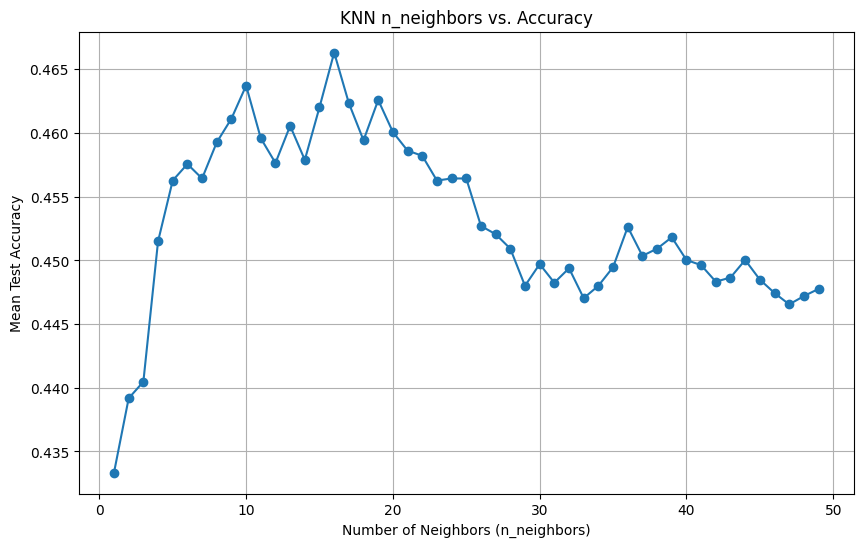

In [6]:
mean_test_scores = clf.cv_results_['mean_test_score']

# Range of n_neighbors
n_neighbors_range = list(range(1, 50))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_range, mean_test_scores, marker='o')
plt.title('KNN n_neighbors vs. Accuracy')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Mean Test Accuracy')
plt.grid(True)
plt.show()

In [11]:
X_test = pd.read_csv(os.path.join("data", "test.csv"))
X_test = scaler.transform(preprocess(X_test))
test_predictions = best_knn.predict(X_test)

submission = {
    "id" : list(range(len(test_predictions))), 
    "price" : list(test_predictions.astype(float))
}

submission = pd.DataFrame.from_dict(submission)

submission.to_csv("bahng_2.csv", index=False)